In [1]:
from numba import cuda

device = cuda.get_current_device(); device.reset()

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import os
import urllib.request
from tqdm import tqdm
from transformers import BertTokenizer, TFBertForSequenceClassification

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/finance_sentiment_corpus/main/finance_data.csv", filename="finance_data.csv")

('finance_data.csv', <http.client.HTTPMessage at 0x255fecb9c70>)

In [4]:
data = pd.read_csv('finance_data.csv')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4846


In [5]:
data

,labels,sentence,kor_sentence
0,neutral,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,neutral,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,negative,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,positive,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,positive,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,런던 마켓워치 -- 은행주의 반등이 FTSE 100지수의 약세를 상쇄하지 못하면서 ...
4842,neutral,Rinkuskiai's beer sales fell by 6.5 per cent t...,린쿠스키아의 맥주 판매량은 416만 리터로 6.5% 감소했으며 카우노 알루스의 맥주...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"영업이익은 2007년 68.8 mn에서 35.4 mn으로 떨어졌으며, 선박 판매 이..."
4844,negative,Net sales of the Paper segment decreased to EU...,페이퍼 부문 순매출은 2008년 2분기 241.1 mn에서 2009년 2분기 221...


In [6]:
data['labels'] = data['labels'].replace(['negative', 'neutral', 'positive'],[0, 1, 2])
data[:5]

,labels,sentence,kor_sentence
0,1,"According to Gran, the company has no plans to...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로..."
1,1,Technopolis plans to develop in stages an area...,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...
2,0,The international electronic industry company ...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ..."
3,2,With the new production plant the company woul...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...
4,2,According to the company's updated strategy fo...,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4..."


In [7]:
del data['kor_sentence']

In [8]:
data[:5]

,labels,sentence
0,1,"According to Gran, the company has no plans to..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company's updated strategy fo...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   labels    4846 non-null   int64 
 1   sentence  4846 non-null   object
dtypes: int64(1), object(1)
memory usage: 75.8+ KB


In [10]:
print('결측값 여부 :',data.isnull().values.any())

결측값 여부 : False


In [11]:
print('kor_sentence 열의 유니크한 값 :',data['sentence'].nunique())

kor_sentence 열의 유니크한 값 : 4838


In [12]:
duplicate = data[data.duplicated()]

In [13]:
duplicate

,labels,sentence
1099,1,The issuer is solely responsible for the conte...
1416,1,The report profiles 614 companies including ma...
2396,1,Ahlstrom's share is quoted on the NASDAQ OMX H...
2567,1,SSH Communications Security Corporation is hea...
3094,1,Proha Plc ( Euronext :7327 ) announced today (...
3206,1,The company serves customers in various indust...


In [14]:
# 중복 제거
data.drop_duplicates(subset=['sentence'], inplace=True)
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 4838


<AxesSubplot:>

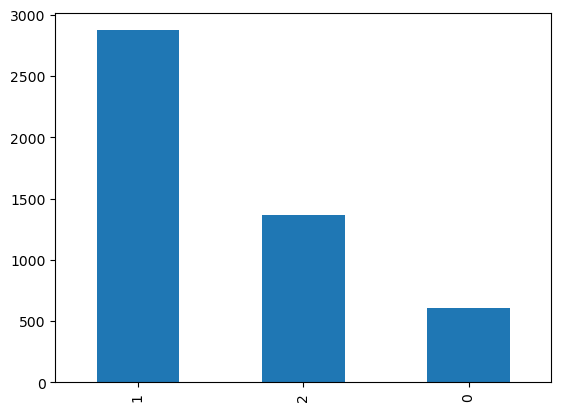

In [15]:
data['labels'].value_counts().plot(kind='bar')

In [16]:
print('레이블의 분포')
print(data.groupby('labels').size().reset_index(name='count'))

레이블의 분포
   labels  count
0       0    604
1       1   2872
2       2   1362


In [17]:
print(f'중립의 비율 = {round(data["labels"].value_counts()[1]/len(data) * 100,3)}%')
print(f'긍정의 비율 = {round(data["labels"].value_counts()[2]/len(data) * 100,3)}%')
print(f'부정의 비율 = {round(data["labels"].value_counts()[0]/len(data) * 100,3)}%')

중립의 비율 = 59.363%
긍정의 비율 = 28.152%
부정의 비율 = 12.484%


In [18]:
data

,labels,sentence
0,1,"According to Gran, the company has no plans to..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company's updated strategy fo...
...,...,...
4841,0,LONDON MarketWatch -- Share prices ended lower...
4842,1,Rinkuskiai's beer sales fell by 6.5 per cent t...
4843,0,Operating profit fell to EUR 35.4 mn from EUR ...
4844,0,Net sales of the Paper segment decreased to EU...


In [19]:
X_data = data['sentence']
y_data = data['labels']
print('본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

본문의 개수: 4838
레이블의 개수: 4838


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [21]:
print('훈련 샘플의 개수 :', len(X_train))
print('테스트 샘플의 개수 :', len(X_test))

훈련 샘플의 개수 : 3870
테스트 샘플의 개수 : 968


In [22]:
print('--------훈련 데이터의 비율-----------')
print(f'중립 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')
print(f'긍정 = {round(y_train.value_counts()[2]/len(y_train) * 100,3)}%')
print(f'부정 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')

--------훈련 데이터의 비율-----------
중립 = 59.354%
긍정 = 28.165%
부정 = 12.481%


In [23]:
print('--------테스트 데이터의 비율-----------')
print(f'중립 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')
print(f'긍정 = {round(y_test.value_counts()[2]/len(y_test) * 100,3)}%')
print(f'부정 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
중립 = 59.401%
긍정 = 28.099%
부정 = 12.5%


In [24]:
max_seq_len = 128

In [25]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [26]:
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [27]:
def convert_examples_to_features(examples, labels, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids, data_labels = [], [], [], []

    for example, label in tqdm(zip(examples, labels), total=len(examples)):
        # input_id는 워드 임베딩을 위한 문장의 정수 인코딩
        input_id = tokenizer.encode(example, max_length=max_seq_len, pad_to_max_length=True)

        # attention_mask는 실제 단어가 위치하면 1, 패딩의 위치에는 0인 시퀀스.
        padding_count = input_id.count(tokenizer.pad_token_id)
        attention_mask = [1] * (max_seq_len - padding_count) + [0] * padding_count

        # token_type_id은 세그먼트 인코딩 -> 문장 2개를 분류나 해석하는 task에선 각 문장이 0과 1로 분류됨.
        token_type_id = [0] * max_seq_len

        # 길이가 다를시 오류메세지 띄워줌.
        assert len(input_id) == max_seq_len, "Error with input length {} vs {}".format(len(input_id), max_seq_len)
        assert len(attention_mask) == max_seq_len, "Error with attention mask length {} vs {}".format(len(attention_mask), max_seq_len)
        assert len(token_type_id) == max_seq_len, "Error with token type length {} vs {}".format(len(token_type_id), max_seq_len)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        data_labels.append(label)

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    data_labels = np.asarray(data_labels, dtype=np.int32)

    return (input_ids, attention_masks, token_type_ids), data_labels

In [28]:
X_train, y_train, max_seq_len

(4328              Most of the layoffs will be in Finland.
 1558    LONDON ICIS -- Tikkurila has completed the sal...
 3582    Exel's board of directors will propose a divid...
 3454    Virala Oy Ab was allocated by the Board of Dir...
 2002    In China, Finnish Kone that provides elevators...
                               ...                        
 2513    mr Bakman sees also expansion options on the T...
 1613    The company designs, manufactures and markets ...
 3616    In 2007, the Group's net sales stood at EUR 42...
 4078    TietoEnator was down 1.13 pct to 18.38, extend...
 328     EPS for the quarter came in at 0.36 eur, up fr...
 Name: sentence, Length: 3870, dtype: object,
 4328    0
 1558    1
 3582    1
 3454    1
 2002    2
        ..
 2513    1
 1613    1
 3616    1
 4078    0
 328     2
 Name: labels, Length: 3870, dtype: int64,
 128)

In [29]:
train_X, train_y = convert_examples_to_features(X_train, y_train, max_seq_len=max_seq_len, tokenizer=tokenizer)

  0%|                                                                                         | 0/3870 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\chan\anaconda3\envs\ng\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 51

In [30]:
train_X, train_y

((array([[  101,  2087,  1997, ...,     0,     0,     0],
         [  101,  2414, 24582, ...,     0,     0,     0],
         [  101,  4654,  2884, ...,     0,     0,     0],
         ...,
         [  101,  1999,  2289, ...,     0,     0,     0],
         [  101,  5495,  3406, ...,     0,     0,     0],
         [  101, 20383,  2005, ...,     0,     0,     0]]),
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 array([0, 1, 1, ..., 1, 0, 2]))

In [31]:
test_X, test_y = convert_examples_to_features(X_test, y_test, max_seq_len=max_seq_len, tokenizer=tokenizer)

100%|██████████████████████████████████████████████████████████████████████████████| 968/968 [00:00<00:00, 2413.98it/s]


In [32]:
input_id = train_X[0][0]
attention_mask = train_X[1][0]
token_type_id = train_X[2][0]
label = train_y[0]

print('단어에 대한 정수 인코딩 :',input_id)
print('어텐션 마스크 :',attention_mask)
print('세그먼트 인코딩 :',token_type_id)
print('각 인코딩의 길이 :', len(input_id))
print('정수 인코딩 복원 :',tokenizer.decode(input_id))
print('레이블 :',label)

단어에 대한 정수 인코딩 : [  101  2087  1997  1996  3913 27475  2097  2022  1999  6435  1012   102
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
어텐션 마스크 : [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [33]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertForSequenceClassification, AdamW

In [34]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [35]:
len(train_X[0]), len(train_y)

(3870, 3870)

In [36]:
# create Tensor datasets
train_data = TensorDataset(torch.tensor(train_X[0]), torch.tensor(train_X[1]), torch.tensor(train_X[2]), torch.tensor(train_y))
valid_data = TensorDataset(torch.tensor(test_X[0]), torch.tensor(test_X[1]), torch.tensor(test_X[2]), torch.tensor(test_y))

# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [37]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [39]:
# epochs = 5
# valid_loss_min = np.Inf

# train_loss = torch.zeros(epochs)
# valid_loss = torch.zeros(epochs)

# train_acc = torch.zeros(epochs)
# valid_acc = torch.zeros(epochs)

# model.to(device)
# for e in tqdm(range(0, epochs)):
#     model.train()
#     # initialize hidden state 
#     # h = model.init_hidden(batch_size)
#     for inputs in tqdm(train_loader):
#         input_ids = inputs[0].to(device)
#         attention_mask = inputs[1].to(device)
#         labels = inputs[3].type(torch.LongTensor).to(device)
#         optimizer.zero_grad()
#         output = model(input_ids, attention_mask=attention_mask, labels=labels)
#         loss = output.loss
#         train_loss[e] += loss.item()
#         loss.backward()
        
#         # calculating accuracy
#         # accuracy = acc(output,labels)
#         ps = F.softmax(output.logits, dim=1)
#         top_p, top_class = ps.topk(1, dim=1)
#         equals = top_class == labels.reshape(top_class.shape)
#         train_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
        
#         #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
#         # nn.utils.clip_grad_norm_(model.parameters(), clip)
#         optimizer.step()
#     train_loss[e] /= len(train_loader)
#     train_acc[e] /= len(train_loader)

    
#     model.eval()
#     for inputs in tqdm(valid_loader):
#         input_ids = inputs[0].to(device)
#         attention_mask = inputs[1].to(device)
#         labels = inputs[3].type(torch.LongTensor).to(device)

#         output = model(input_ids, attention_mask=attention_mask, labels=labels)
#         val_loss = output.loss
#         valid_loss[e] += val_loss.item()

#         ps = F.softmax(output.logits, dim=1)
#         top_p, top_class = ps.topk(1, dim=1)
#         equals = top_class == labels.reshape(top_class.shape)
#         valid_acc[e] += torch.mean(equals.type(torch.float)).detach().cpu()
#     valid_loss[e] /= len(valid_loader)
#     valid_acc[e] /= len(valid_loader)
    
#     print(f'Epoch {e+1}') 
#     print(f'train_loss : {train_loss[e]}, val_loss : {valid_loss[e]}')
#     print(f'train_accuracy : {train_acc[e]*100}, val_accuracy : {valid_acc[e]*100}')
#     if valid_loss[e] <= valid_loss_min:
#         torch.save(model, 'bert_model.pth')
#         torch.save(model.state_dict(), 'bert_model_state_dict.pt')
#         print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss[e]))
#         valid_loss_min = valid_loss[e]
#     print(25*'==')

In [61]:
import os
import pandas as pd

path = "C:/Users/chan/Documents/GitHub/ML/test4/"
news_df = pd.DataFrame(columns=["title", "content"])

for txts in os.listdir(path):
    full_path = os.path.join(path, txts)  # 파일 전체 경로 생성
    if os.path.isfile(full_path):  # 파일인지 확인
        with open(full_path, "r", encoding="utf-8") as txt_file:
            title = txt_file.readline().strip()
            content = txt_file.read().replace('\n', ' ')
            # DataFrame 생성 후 concat 함수를 사용하여 추가
            new_row = pd.DataFrame({"title": [title], "content": [content]})
            news_df = pd.concat([news_df, new_row], ignore_index=True)

news_df


,title,content
0,"Wed, 05 Apr 2023 07:00:00 GMT",Tesla Inc. ’s sprawling manufacturing hub in ...
1,"Fri, 07 Apr 2023 07:00:00 GMT",FILE - A Tesla electric vehicle emblem is aff...
2,"Tue, 25 Apr 2023 07:00:00 GMT","With over 1 million estimated reservations, t..."
3,"Wed, 18 Oct 2023 07:00:00 GMT",Tesla (TSLA) released its financial results a...
4,"Wed, 18 Oct 2023 07:00:00 GMT",Tesla stock is down 3% during after-hours tra...
...,...,...
2824,"Wed, 18 Oct 2023 07:00:00 GMT",Tesla reported one of its weakest earnings re...
2825,"Wed, 18 Oct 2023 07:00:00 GMT",Tesla (TSLA) announced third-quarter results ...
2826,"Thu, 19 Oct 2023 07:00:00 GMT",Tesla (NASDAQ: TSLA) Earnings tempered analys...
2827,"Thu, 19 Oct 2023 07:00:00 GMT","Tesla, Inc. misses on earnings expectations. ..."


In [60]:
# import os
# import pandas as pd

# path = "C:/Users/chan/Documents/GitHub/ML/articles/"
# news_df = pd.DataFrame(columns=["title", "content"])


# for txts in os.listdir(path):
    
#     full_path = os.path.join(path, txts)  # 파일 전체 경로 생성
#     if os.path.isfile(full_path):  # 파일인지 확인
#         with open(full_path, "r", encoding="utf-8") as txt_file:
#             title = txt_file.readline().strip()
#             content = txt_file.read().replace('\n', ' ')
#             news_df = news_df.append({"title": title, "content": content}, ignore_index=True)
# news_df

In [62]:
# 데이터프레임의 'title'과 'content'를 이용하여 입력 데이터 생성
inputs = [content for content in news_df['content']]

# 입력 데이터를 BERT 모델의 입력 형식에 맞게 변환
max_length = 128
input_ids = []
attention_masks = []

for content in inputs:
    encoded_dict = tokenizer.encode_plus(
                        content,                    # content
                        add_special_tokens = True,  # Add '[CLS]' and '[SEP]'
                        max_length = max_length,           # Pad & truncate all sentences
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks
                        return_tensors = 'pt',     # Return pytorch tensors
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

C:\Users\chan\anaconda3\envs\ng\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [63]:
predict_model = torch.load("bert_model_loss0.34.pth", map_location=torch.device('cpu'))
predict_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [64]:
predicted_labels = []

for inputs in tqdm(zip(input_ids, attention_masks)):
    input_ids = inputs[0].to(device)
    attention_mask = inputs[1].to(device)
    output = predict_model(input_ids, attention_mask=attention_mask)

    ps = F.softmax(output.logits, dim=1)
    top_p, top_class = ps.topk(1, dim=1)
    predicted_labels.append(top_class.item())

predict_df = pd.DataFrame({'predicted_label': predicted_labels})
news_df["predict"] = predict_df
news_df.to_csv('predicted_news.csv', index=False)

2829it [03:22, 13.94it/s]


In [65]:
news_df

,title,content,predict
0,"Wed, 05 Apr 2023 07:00:00 GMT",Tesla Inc. ’s sprawling manufacturing hub in ...,2
1,"Fri, 07 Apr 2023 07:00:00 GMT",FILE - A Tesla electric vehicle emblem is aff...,0
2,"Tue, 25 Apr 2023 07:00:00 GMT","With over 1 million estimated reservations, t...",1
3,"Wed, 18 Oct 2023 07:00:00 GMT",Tesla (TSLA) released its financial results a...,1
4,"Wed, 18 Oct 2023 07:00:00 GMT",Tesla stock is down 3% during after-hours tra...,0
...,...,...,...
2824,"Wed, 18 Oct 2023 07:00:00 GMT",Tesla reported one of its weakest earnings re...,1
2825,"Wed, 18 Oct 2023 07:00:00 GMT",Tesla (TSLA) announced third-quarter results ...,0
2826,"Thu, 19 Oct 2023 07:00:00 GMT",Tesla (NASDAQ: TSLA) Earnings tempered analys...,0
2827,"Thu, 19 Oct 2023 07:00:00 GMT","Tesla, Inc. misses on earnings expectations. ...",0


In [67]:
import os
import pandas as pd

# 데이터프레임과 데이터 로드 부분은 생략합니다.

# 'title' 열에서 날짜와 시간을 분리
news_df['date'] = pd.to_datetime(news_df['title']).dt.date  # 날짜 추출
news_df['time'] = pd.to_datetime(news_df['title']).dt.time  # 시간 추출

# 날짜별로 그룹화하고, 'predict' 열에 대한 평균을 계산
grouped_df = news_df.groupby('date').agg({
    'title': lambda x: x.tolist(),
    'content': lambda x: x.tolist(),
    'predict': lambda x: round(x.mean(), 3)  
})

grouped_df.reset_index(inplace=True)  # 인덱스 리셋

# 결과 출력
grouped_df[['date', 'title', 'content', 'predict']]


,date,title,content,predict
0,2023-04-05,"[Wed, 05 Apr 2023 07:00:00 GMT, Wed, 05 Apr 20...",[ Tesla Inc. ’s sprawling manufacturing hub in...,1.000
1,2023-04-06,"[Thu, 06 Apr 2023 07:00:00 GMT, Thu, 06 Apr 20...",[ Tesla board member and brother of CEO Elon M...,1.000
2,2023-04-07,"[Fri, 07 Apr 2023 07:00:00 GMT, Fri, 07 Apr 20...",[ FILE - A Tesla electric vehicle emblem is af...,0.200
3,2023-04-08,"[Sat, 08 Apr 2023 07:00:00 GMT]",[ Electric vehicle (EV) stocks surged off thei...,2.000
4,2023-04-09,"[Sun, 09 Apr 2023 07:00:00 GMT, Sun, 09 Apr 20...",[ Tesla Inc. will build a large new battery fa...,1.500
...,...,...,...,...
358,2024-04-02,"[Tue, 02 Apr 2024 07:00:00 GMT, Tue, 02 Apr 20...",[ Tesla shares fell on Tuesday after the compa...,0.778
359,2024-04-03,"[Wed, 03 Apr 2024 21:45:20 GMT, Wed, 03 Apr 20...",[ Tesla (TSLA) closed the latest trading day a...,0.222
360,2024-04-04,"[Thu, 04 Apr 2024 04:20:15 GMT, Thu, 04 Apr 20...","[ Despite recent setbacks, one analyst is opti...",0.250
361,2024-04-05,"[Fri, 05 Apr 2024 17:00:40 GMT, Fri, 05 Apr 20...",[ Tesla Inc. shares pared a steep drop in intr...,0.412


In [79]:
result_df = grouped_df[['date', 'predict']]
result_df

,date,predict
0,2023-04-05,1.000
1,2023-04-06,1.000
2,2023-04-07,0.200
3,2023-04-08,2.000
4,2023-04-09,1.500
...,...,...
358,2024-04-02,0.778
359,2024-04-03,0.222
360,2024-04-04,0.250
361,2024-04-05,0.412


In [81]:
import os
import pandas as pd

# 데이터프레임과 데이터 로드 부분은 생략합니다.

# 'title' 열에서 날짜와 시간을 분리
news_df['date'] = pd.to_datetime(news_df['title']).dt.date  # 날짜 추출
news_df['time'] = pd.to_datetime(news_df['title']).dt.time  # 시간 추출

# 'date' 열을 datetime 형식으로 다시 변환
news_df['date'] = pd.to_datetime(news_df['date'])

# 날짜별로 그룹화하고, 'predict' 열에 대한 평균을 계산
grouped_df = news_df.groupby('date').agg({
    'title': lambda x: x.tolist(),
    'content': lambda x: x.tolist(),
    'predict': lambda x: round(x.mean(), 3)  
})

grouped_df.reset_index(inplace=True)  # 인덱스 리셋

# 모든 날짜를 포함하는 날짜 범위 생성
all_dates = pd.date_range(start=grouped_df['date'].min(), end=grouped_df['date'].max(), freq='D')
# 새로운 DataFrame 생성 후 기존 데이터와 병합
complete_df = pd.DataFrame(all_dates, columns=['date'])
complete_df['date'] = pd.to_datetime(complete_df['date'])  # 날짜를 datetime으로 변환
complete_df = complete_df.merge(grouped_df, on='date', how='left')
# 누락된 'predict' 값을 이전 값으로 채우기
complete_df['predict'] = complete_df['predict'].fillna(method='ffill')

# 'date'와 'predict' 열만 선택하여 결과 출력
result_df = complete_df[['date', 'predict']]
result_df


,date,predict
0,2023-04-05,1.000
1,2023-04-06,1.000
2,2023-04-07,0.200
3,2023-04-08,2.000
4,2023-04-09,1.500
...,...,...
363,2024-04-02,0.778
364,2024-04-03,0.222
365,2024-04-04,0.250
366,2024-04-05,0.412


In [87]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# 날짜열을 datetime으로 변환
grouped_df['date'] = pd.to_datetime(news_df['date'])

# 미국 연방 공휴일 캘린더를 생성
cal = USFederalHolidayCalendar()

# 연방 공휴일 목록을 가져옵니다 (여기서는 2023년과 2024년만 고려)
holidays = cal.holidays(start=grouped_df['date'].min(), end=grouped_df['date'].max())

# 공휴일에 해당하지 않는 날짜들만 필터링하여 새로운 DataFrame 생성
df_non_holidays = grouped_df[~grouped_df['date'].isin(holidays)]

df_non_holidays  # 결과 출력
holidays


DatetimeIndex(['2023-05-29', '2023-06-19', '2023-07-04', '2023-09-04',
               '2023-10-09', '2023-11-10', '2023-11-23'],
              dtype='datetime64[ns]', freq=None)

<Axes: xlabel='predict'>

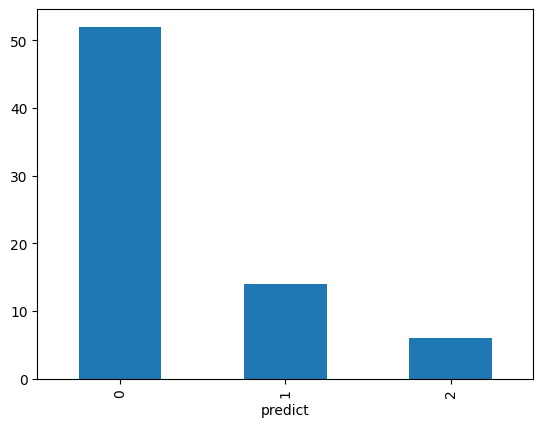

In [45]:
news_df['predict'].value_counts().plot(kind='bar')

In [68]:
import numpy as np
import pandas as pd

import pandas_datareader.data as web # 주식 데이터를 얻어오기 위해 사용
import datetime # 시간 처리
import matplotlib.pyplot as plt
import yfinance as yf
import FinanceDataReader as fdr
from prophet import Prophet
%matplotlib inline

# 데이터를 가져오고 나서, 이동평균을 구해야함.
# 국내 종목 : 삼성전자

# 날짜 : 3년 간 삼성전자 주가 분석(2017.01.02) ~ (2021.06.07)
start = datetime.datetime( 2023, 4, 5 )
end = datetime.datetime( 2024, 4, 5)

C:\Users\chan\anaconda3\envs\ng\lib\site-packages\yfinance\base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [69]:
def makeStockChart(code, sDay, eDay):
    """
    이 함수는 종목코드와 조회 시작일, 종료일을 넣으면 차트를 그려준다.
    이동 평균선은 5일, 20일, 60일, 120일을 지원한다.
    """
    
    # 데이터 가져오기
    data = yf.download(code, start=sDay, end=eDay)
    
    # 이동 평균 계산
    data['5MA'] = data['Adj Close'].rolling(window=5).mean()
    data['20MA'] = data['Adj Close'].rolling(window=20).mean()
    data['60MA'] = data['Adj Close'].rolling(window=60).mean()
    data['120MA'] = data['Adj Close'].rolling(window=120).mean()
    
    # 차트 그리기
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close')
    plt.plot(data['5MA'], label='5MA')
    plt.plot(data['20MA'], label='20MA')
    plt.plot(data['60MA'], label='60MA')
    plt.plot(data['120MA'], label='120MA')
    plt.title(f"{code}'s Stock Chart")
    plt.legend()
    plt.show()

[*********************100%%**********************]  1 of 1 completed


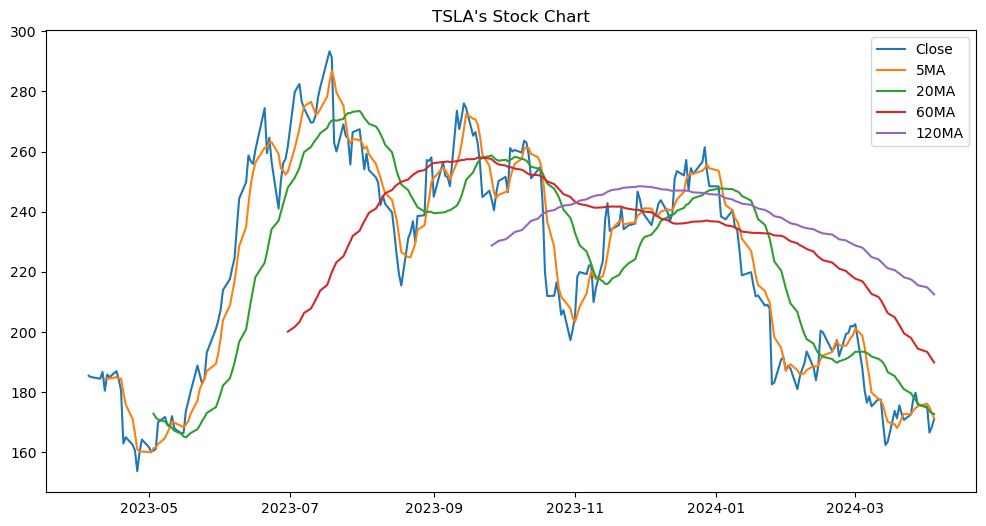

In [70]:
code_name = 'TSLA'
makeStockChart(code_name, start, end)

In [109]:
datas = yf.download(code_name, start=start, end=end)

# 컬럼 ds(YYYY-MM-DD), y(종가 : Close) 구성
# 해당 구저의 DateFrame만들기 위한 딕셔너리 선언

dic = {
    'ds' : datas.index,
    'y' : datas.Close
}

# ds 와 y를 컬럼으로 갖는 데이터 프레임 생성
finance_df = pd.DataFrame( dic )

#인덱스 초기화(원본 까지 적용)
finance_df.reset_index( inplace=True )

# 'ds' 컬럼과 중복되는 'Date' 컬럼 제거
del finance_df['Date']

# 페이스북의 시계열 예측 모델에 사용한 데이터 준비
finance_df.head(5)
finance_df.tail(5)
# print(len(finance_df))

[*********************100%%**********************]  1 of 1 completed


,ds,y
246,2024-03-28,175.789993
247,2024-04-01,175.220001
248,2024-04-02,166.630005
249,2024-04-03,168.380005
250,2024-04-04,171.110001


In [72]:
import pandas as pd
import datetime

# 정해진 기간을 데이터프레임화
start = datetime.datetime(2023, 4, 5)
end = datetime.datetime(2024, 4, 5)

# start와 end 사이의 날짜를 포함하는 DataFrame 생성
date_range = pd.date_range(start=start, end=end)
df_date_range = pd.DataFrame(date_range, columns=['date'])

# 다른 데이터프레임 예시 생성


# df_date_range에서 other_dates의 date와 겹치는 날짜를 제거
df_filtered = df_date_range[~df_date_range['date'].isin(df['ds'])]
df_filtered #미국주식 안열리는 날 계산한 데이터 프레임

,date
2,2023-04-07
3,2023-04-08
4,2023-04-09
10,2023-04-15
11,2023-04-16
...,...
354,2024-03-24
359,2024-03-29
360,2024-03-30
361,2024-03-31


In [101]:
# 겹치는 날짜 
common_dates = result_df[result_df['date'].isin(df_filtered['date'])]['date']

# 겹치는 날짜를 갖는 행 제거
result_filtered = result_df[~result_df['date'].isin(common_dates)]
result_filtered = result_filtered.iloc[:-1]
result_filtered

,date,predict
0,2023-04-05,1.000
1,2023-04-06,1.000
5,2023-04-10,0.333
6,2023-04-11,0.333
7,2023-04-12,0.667
...,...,...
358,2024-03-28,0.833
362,2024-04-01,0.645
363,2024-04-02,0.778
364,2024-04-03,0.222


In [102]:
result_filtered.reset_index(inplace=True)
result_filtered

,index,date,predict
0,0,2023-04-05,1.000
1,1,2023-04-06,1.000
2,5,2023-04-10,0.333
3,6,2023-04-11,0.333
4,7,2023-04-12,0.667
...,...,...,...
246,358,2024-03-28,0.833
247,362,2024-04-01,0.645
248,363,2024-04-02,0.778
249,364,2024-04-03,0.222


In [111]:
# finance_df = pd.concat([finance_df, result_filtered['predict']], axis=1)

# finance_df

,ds,y,predict
0,2023-04-05,185.520004,1.000
1,2023-04-06,185.059998,1.000
2,2023-04-10,184.509995,0.333
3,2023-04-11,186.789993,0.333
4,2023-04-12,180.539993,0.667
...,...,...,...
246,2024-03-28,175.789993,0.833
247,2024-04-01,175.220001,0.645
248,2024-04-02,166.630005,0.778
249,2024-04-03,168.380005,0.222


            ds        yhat  yhat_lower  yhat_upper
240 2024-03-20  179.536304  159.027368  200.848507
241 2024-03-21  179.708634  159.768781  202.034670
242 2024-03-22  172.392318  151.722406  195.627270
243 2024-03-25  172.155596  150.473787  192.778001
244 2024-03-26  171.485849  149.571694  191.790537
245 2024-03-27  172.716435  150.849507  192.576999
246 2024-03-28  174.367093  153.439523  194.268752
247 2024-04-01  169.075770  146.085430  191.128575
248 2024-04-02  170.010704  148.690794  190.867720
249 2024-04-03  165.188990  144.534782  186.676380
250 2024-04-04  162.985887  141.419899  183.401333


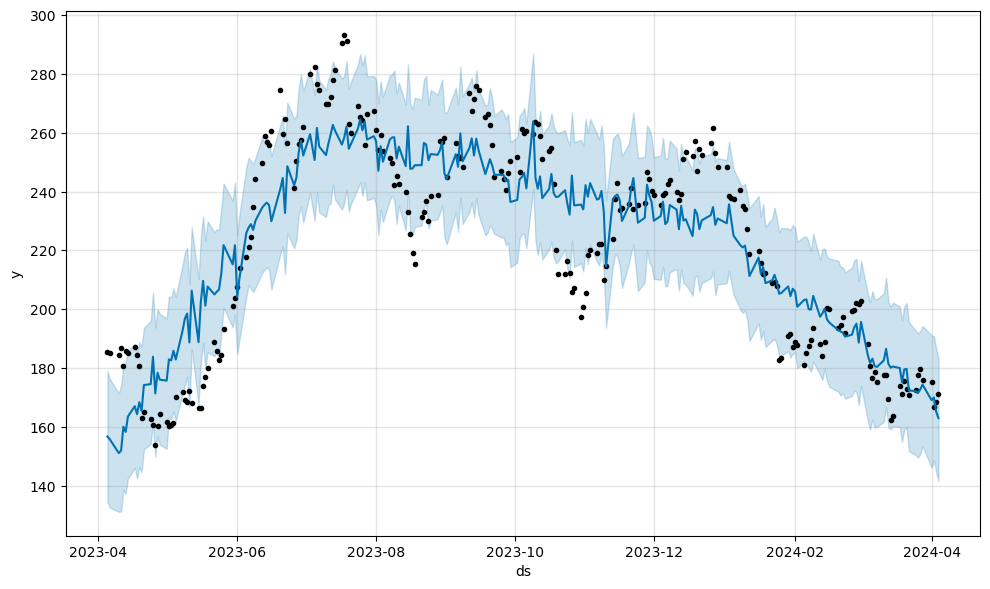

In [114]:
import logging
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

# Day 단위로 데이터가 구성되어 있으므로, 일 단위 주기성 활성화
model = Prophet( daily_seasonality=True,
               ) 
model.add_country_holidays(country_name='US')
model.add_regressor('predict')
# 데이터 학습 시작 -> 기계학습
model.fit( finance_df )

# 주가 예측 위한 날짜 데이터 세팅 -> 기존 데이터 + 향후 10일치 예측값
future = model.make_future_dataframe( periods = 0)
future['predict'] = result_filtered['predict'].values
# 주가 예측
forecast = model.predict( future )

# forecast.columns ->
'''
  Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
''' 

# 모델 예측 결과 출력
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(11))

# 모델 예측 그래프 출력
fig = model.plot(forecast)

plt.show(fig)


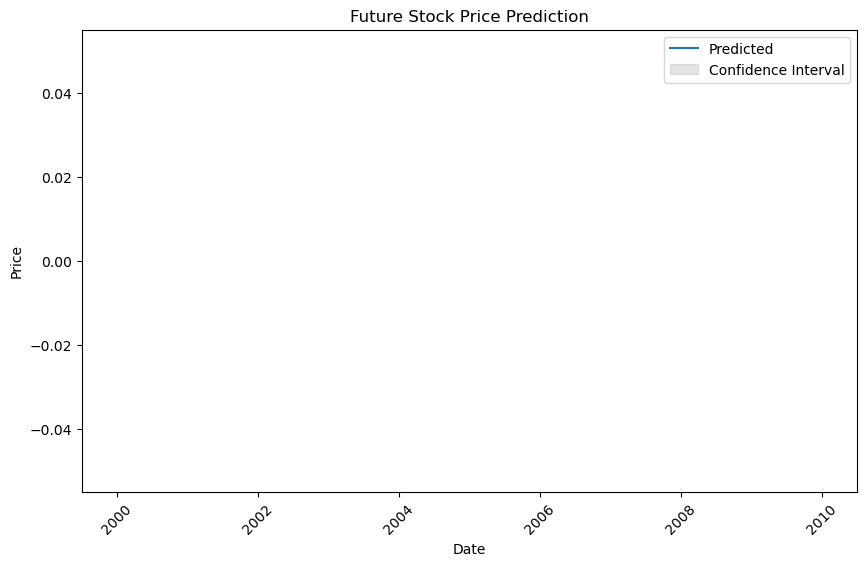

In [115]:
# import matplotlib.pyplot as plt

# # 기존 데이터의 마지막 날짜 찾기
# last_date = df['ds'].max()

# # forecast 데이터프레임에서 기존 데이터의 마지막 날짜 이후 부분만 필터링
# future_forecast = forecast[forecast['ds'] > last_date]

# # 필터링된 향후 예측값만 시각화
# plt.figure(figsize=(10, 6))
# plt.plot(future_forecast['ds'], future_forecast['yhat'], label='Predicted')
# plt.fill_between(future_forecast['ds'], future_forecast['yhat_lower'], future_forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')

# plt.title('Future Stock Price Prediction')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.xticks(rotation=45)  # 날짜 라벨을 45도 회전하여 겹침 방지
# plt.show()


In [116]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 실제 값과 예측 값을 필터링하여 준비
# df 데이터프레임에서 실제 'y' 값을 가져오고, 이를 forecast 데이터프레임의 'ds'에 맞춥니다.
actual = df.set_index('ds')['y']
predictions = forecast.set_index('ds')['yhat'].reindex(actual.index)

# 평균 절대 오차(MAE)
mae = mean_absolute_error(actual, predictions)

# 평균 제곱 오차(MSE)
mse = mean_squared_error(actual, predictions)

# 결정계수(R²)
r2 = r2_score(actual, predictions)

# 결과 출력
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")


MAE: 13.71726235003987
MSE: 282.7515841134941
R²: 0.7790590849846953


In [120]:
initial_capital = 1000.0  # 초기 자본
current_capital = initial_capital  # 현재 자본, 거래 과정에서 업데이트됨
shares_owned = 0
position = 'None'  # 현재 포지션 상태
day = 180
month_day = 30
# 시뮬레이션 수익 계산
profit = 0.0

actual_prices = df.set_index('ds')['y'][-(day+31):-(day)]  # 마지막 31일 실제 가격
predicted_prices = forecast.set_index('ds')['yhat'][-(day+31):-(day)]

dates = [actual_prices.index[0] - pd.Timedelta(days=1)]  # 첫 거래일 이전 날짜 추가
capitals = [initial_capital]

# 날짜와 함께 매도, 매수, 보유 결과를 출력하기 위해 수정
for i in range(month_day):
    today_date = actual_prices.index[i]
    today_price = actual_prices.iloc[i]
    predicted_next_day_price = predicted_prices.iloc[i]

    # 조건을 검사하고 매수, 매도, 보유를 결정
    if i < (month_day-1):  # 마지막 날짜를 제외한 모든 날에 대해 검사
        next_day_price = actual_prices.iloc[i+1]
        predicted_change = predicted_next_day_price - today_price

        # 매수 조건
        if predicted_change > 0 and position != 'Hold':
            shares_owned = current_capital / today_price
            current_capital = 0
            position = 'Hold'
            print(f"{today_date} - 매수: {today_price} (실제 다음날 가격: {next_day_price:,.3f}, 예측된 다음날 가격: {predicted_next_day_price:,.3f})")

        # 매도 조건
        elif predicted_change < 0 and position == 'Hold':
            current_capital = shares_owned * next_day_price
            shares_owned = 0
            position = 'None'
            print(f"{today_date} - 매도: {next_day_price} (실제 다음날 가격: {next_day_price:,.3f}, 예측된 다음날 가격: {predicted_next_day_price:,.3f})")

        # 보유 조건
        elif position == 'Hold' and abs(predicted_change) <= 0.01 * today_price:
            print(f"{today_date} - 보유: {today_price}")
        else:
    # 보유 또는 기타 조건 로직
            if position == 'Hold':
                print(f"{today_date} - 보유: 현재 가격 {today_price:,.3f}, 예측된 다음날 가격 {predicted_next_day_price:,.3f}")
            else:
                print(f"{today_date} - 조치 없음: 현재 가격 {today_price:,.3f}, 예측된 다음날 가격 {predicted_next_day_price:,.3f}")
    dates.append(today_date)
    capitals.append(current_capital + (shares_owned * today_price))
# 마지막 날 주식을 모두 매도하고 최종 자본 계산
if position == 'Hold' and shares_owned > 0:
    final_price = actual_prices.iloc[-1]
    current_capital = shares_owned * final_price
    shares_owned = 0
    print(f"{actual_prices.index[-1]} - 마지막 날 매도: {final_price:,.3f}")

profit = current_capital - initial_capital  # 최종 이익 계산
return_rate = ((current_capital - initial_capital) / initial_capital) * 100
# 결과 출력
print(f"초기 자본: ${initial_capital:,.3f}")
print(f"최종 자본: ${current_capital:,.3f}")
print(f"수익: ${profit:,.3f}")
print(f"수익률: {return_rate:.2f}%")

2023-06-02 00:00:00 - 조치 없음: 현재 가격 213.970, 예측된 다음날 가격 210.600
2023-06-05 00:00:00 - 매수: 217.61000061035156 (실제 다음날 가격: 221.310, 예측된 다음날 가격: 225.918)
2023-06-06 00:00:00 - 보유: 현재 가격 221.310, 예측된 다음날 가격 227.751
2023-06-07 00:00:00 - 보유: 현재 가격 224.570, 예측된 다음날 가격 228.931
2023-06-08 00:00:00 - 매도: 244.39999389648438 (실제 다음날 가격: 244.400, 예측된 다음날 가격: 226.968)
2023-06-09 00:00:00 - 조치 없음: 현재 가격 244.400, 예측된 다음날 가격 230.089
2023-06-12 00:00:00 - 조치 없음: 현재 가격 249.830, 예측된 다음날 가격 234.566
2023-06-13 00:00:00 - 조치 없음: 현재 가격 258.710, 예측된 다음날 가격 235.501
2023-06-14 00:00:00 - 조치 없음: 현재 가격 256.790, 예측된 다음날 가격 236.227
2023-06-15 00:00:00 - 조치 없음: 현재 가격 255.900, 예측된 다음날 가격 235.351
2023-06-16 00:00:00 - 조치 없음: 현재 가격 260.540, 예측된 다음날 가격 229.892
2023-06-20 00:00:00 - 조치 없음: 현재 가격 274.450, 예측된 다음날 가격 241.142
2023-06-21 00:00:00 - 조치 없음: 현재 가격 259.460, 예측된 다음날 가격 244.609
2023-06-22 00:00:00 - 조치 없음: 현재 가격 264.610, 예측된 다음날 가격 232.728
2023-06-23 00:00:00 - 조치 없음: 현재 가격 256.600, 예측된 다음날 가격 248.597
2023-06-26 00